In [1]:
!pip install konlpy
!pip install python-mecab-ko

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 580.9/580.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 20.4 MB/s eta 0:00:00


In [11]:
from konlpy.tag import Okt, Mecab
from nltk.tokenize import WordPunctTokenizer

# 선택지: 'Okt', 'Mecab', 'Whitespace', 'WordPunct'
tokenizer_name = 'Okt'

# 토크나이저 객체 준비
okt = Okt()
try:
    mecabs = Mecab()
    print('Mecab successfully loaded.')
except Exception as e:
    print('Mecab not installed.', e)

wordpunct = WordPunctTokenizer()

def tokenizer(sentence):
    sentence = str(sentence)  # NaN 방지
    if tokenizer_name == 'Okt':
        return okt.morphs(sentence)
    elif tokenizer_name == 'Mecab':
        return mecabs.morphs(sentence)
    elif tokenizer_name == 'Whitespace':
        return sentence.split()
    elif tokenizer_name == 'WordPunct':
        return wordpunct.tokenize(sentence)
    else:
        raise ValueError(f"지원하지 않는 토크나이저: {tokenizer_name}")


Mecab not installed. Install MeCab in order to use it: http://konlpy.org/en/latest/install/


100%|██████████| 250/250 [00:15<00:00, 15.92it/s]
/tmp/ipython-input-21-3164213806.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='Mean', hue='Metric', data=subset_df, capsize=.03, errcolor='gray', ci=None)
/tmp/ipython-input-21-3164213806.py:110: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(x='Model', y='Mean', hue='Metric', data=subset_df, capsize=.03, errcolor='gray', ci=None)



▶️ Precision / Recall / F0.5 Table
Metric               F0.5      Precision         Recall
Model                                                  
BUSAN       0.773 (0.323)  0.921 (0.206)  0.744 (0.352)
DAUM        0.689 (0.398)  0.977 (0.104)  0.611 (0.421)
GPT         0.807 (0.338)  0.929 (0.212)  0.808 (0.333)
Naver       0.757 (0.347)  0.967 (0.129)  0.675 (0.388)
Sentencify  0.865 (0.257)  0.927 (0.212)  0.855 (0.273)

▶️ BLEU / GLEU Table
Metric               BLEU           GLEU
Model                                   
BUSAN       0.788 (0.221)  0.802 (0.203)
DAUM        0.780 (0.226)  0.795 (0.206)
GPT         0.804 (0.204)  0.815 (0.188)
Naver       0.812 (0.211)  0.823 (0.195)
Sentencify  0.836 (0.204)  0.846 (0.189)


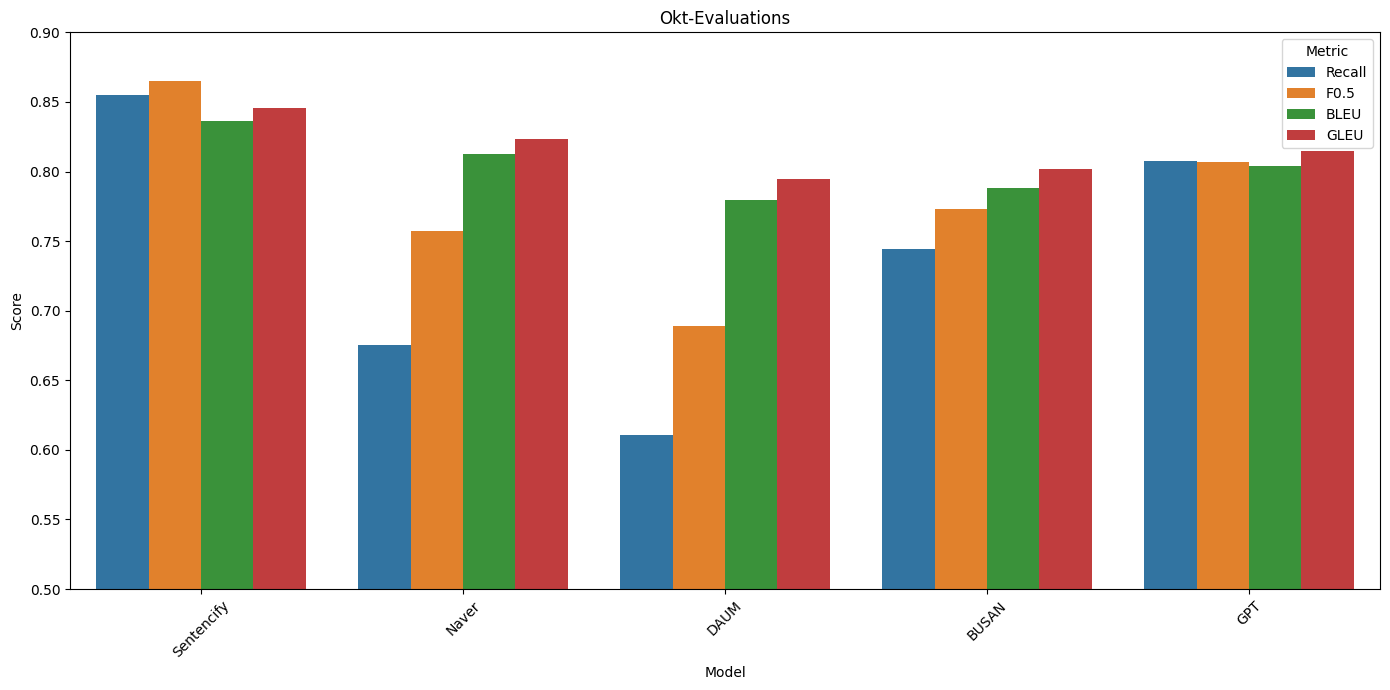

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from konlpy.tag import Okt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.gleu_score import sentence_gleu


# BLEU, GLEU 계산
def compute_scores(reference_sentence, hypothesis_sentence):
    reference = [tokenizer(reference_sentence)]
    hypothesis = tokenizer(hypothesis_sentence)
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smoothie)
    gleu_score = sentence_gleu(reference, hypothesis)
    return bleu_score, gleu_score

# Precision, Recall, F0.5 계산
def get_diff_indices(src_tokens, trg_tokens):
    diff_indices = []
    length = max(len(src_tokens), len(trg_tokens))
    for i in range(length):
        src_tok = src_tokens[i] if i < len(src_tokens) else None
        trg_tok = trg_tokens[i] if i < len(trg_tokens) else None
        if src_tok != trg_tok:
            diff_indices.append(i)
    return set(diff_indices)

def compute_precision_recall_f05(src_sent, pred_sent, gold_sent, tokenizer):
    src_tokens = tokenizer(src_sent)
    pred_tokens = tokenizer(pred_sent)
    gold_tokens = tokenizer(gold_sent)

    pred_edit_indices = get_diff_indices(src_tokens, pred_tokens)
    gold_error_indices = get_diff_indices(src_tokens, gold_tokens)

    correct_indices = pred_edit_indices.intersection(gold_error_indices)

    precision = len(correct_indices) / len(pred_edit_indices) if pred_edit_indices else 1.0
    recall = len(correct_indices) / len(gold_error_indices) if gold_error_indices else 1.0

    beta = 0.5
    if precision + recall == 0:
        f05 = 0.0
    else:
        f05 = (1 + beta ** 2) * precision * recall / ((beta ** 2) * precision + recall)

    return precision, recall, f05

# CSV 파일 읽기
df = pd.read_csv('Testing_corrected_with_spell.csv')

# 평가 대상 컬럼
pred_columns = ['Sentencify', 'NAVER', 'DAUM', 'BUSAN', 'GPT']

# 결과 저장용 딕셔너리
results = {model: {'Precision': [], 'Recall': [], 'F0.5': [], 'BLEU': [], 'GLEU': []} for model in pred_columns}

# 점수 계산
for idx, row in tqdm(df.iterrows(), total=len(df)):
    src = row['ko']
    ans = row['corrected']
    for model in pred_columns:
        pred = row[model]

        # Precision, Recall, F0.5
        p, r, f05 = compute_precision_recall_f05(src, pred, ans, tokenizer)
        results[model]['Precision'].append(p)
        results[model]['Recall'].append(r)
        results[model]['F0.5'].append(f05)

        # BLEU, GLEU
        bleu, gleu = compute_scores(ans, pred)
        results[model]['BLEU'].append(bleu)
        results[model]['GLEU'].append(gleu)

# 통계 요약
summary = {'Model': [], 'Metric': [], 'Mean': [], 'Std': []}
for model in pred_columns:
    for metric in ['Precision', 'Recall', 'F0.5', 'BLEU', 'GLEU']:
        mean_score = sum(results[model][metric]) / len(results[model][metric])
        std_score = pd.Series(results[model][metric]).std()
        summary['Model'].append(model)
        summary['Metric'].append(metric)
        summary['Mean'].append(mean_score)
        summary['Std'].append(std_score)

summary_df = pd.DataFrame(summary)

# Mean (Std) 포맷으로 표기
summary_df['Formatted'] = summary_df.apply(lambda row: f"{row['Mean']:.3f} ({row['Std']:.3f})", axis=1)

# Precision/Recall/F0.5 표
prf_table = summary_df[summary_df['Metric'].isin(['Precision', 'Recall', 'F0.5'])]
prf_pivot = prf_table.pivot(index='Model', columns='Metric', values='Formatted')
print("\n▶️ Precision / Recall / F0.5 Table")
print(prf_pivot)

# BLEU/GLEU 표
bleu_table = summary_df[summary_df['Metric'].isin(['BLEU', 'GLEU'])]
bleu_pivot = bleu_table.pivot(index='Model', columns='Metric', values='Formatted')
print("\n▶️ BLEU / GLEU Table")
print(bleu_pivot)

# 시각화 함수
def plot_metrics(subset_metrics, title, legend_loc='upper right'):
    plt.figure(figsize=(14, 7))
    subset_df = summary_df[summary_df['Metric'].isin(subset_metrics)]
    sns.barplot(x='Model', y='Mean', hue='Metric', data=subset_df, capsize=.03, errcolor='gray', ci=None)

    plt.title(title)
    plt.ylabel('Score')
    plt.ylim(0.5, 0.9)
    plt.legend(title='Metric', loc=legend_loc)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 그래프 그리기
'''
plot_metrics(['Precision', 'Recall', 'F0.5'], tokenizer_name + '-P/R/F0.5', legend_loc='upper right')
plot_metrics(['BLEU', 'GLEU'], tokenizer_name + '-BLEU/GLEU', legend_loc='upper left')
'''
plot_metrics(['Recall','F0.5','BLEU','GLEU'], tokenizer_name + '-Evaluations', legend_loc='upper right')